In [1]:
import glob
import os
from PIL import Image, ImageOps
import numpy as np
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
z = glob.glob('train/*/*.png')
#z = glob.glob('test_train/*/*.png')
ori_label = []
ori_imgs = []
for fn in z:
    if fn[-3:] != 'png':
        continue
    ori_label.append(fn.split('/')[-2])
    new_img = Image.open(fn)
    ori_imgs.append(ImageOps.fit(new_img, (48, 48), Image.ANTIALIAS).convert('RGB'))
#print(z)

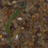

In [3]:
ori_imgs[1]

In [4]:
imgs = np.array([np.array(im) for im in ori_imgs])
imgs = imgs.reshape(imgs.shape[0], 48, 48, 3) / 255
lb = LabelBinarizer().fit(ori_label)
label = lb.transform(ori_label) 

In [5]:
trainX, validX, trainY, validY = train_test_split(imgs, label, test_size=0.05, random_state=42)

In [6]:
from keras.layers import Dropout, Input, Dense, Activation,GlobalMaxPooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
IM_input = Input((48, 48, 3))
IM = Conv2D(16, (3, 3))(IM_input)
IM = BatchNormalization(axis = 3)(IM)
IM = Activation('relu')(IM)
IM = Conv2D(16, (3, 3))(IM)
IM = BatchNormalization(axis = 3)(IM)
IM = Activation('relu')(IM)
IM = MaxPooling2D((2, 2), strides=(2, 2))(IM)
IM = Conv2D(32, (3, 3))(IM)
IM = BatchNormalization(axis = 3)(IM)
IM = Activation('relu')(IM)
IM = Conv2D(32, (3, 3))(IM)
IM = BatchNormalization(axis = 3)(IM)
IM = Activation('relu')(IM)
IM = GlobalMaxPooling2D()(IM)

IM = Dense(64, activation='relu')(IM)
IM = Dropout(0.5)(IM)
IM = Dense(32, activation='relu')(IM)
IM = Dropout(0.5)(IM)
IM = Dense(12, activation='softmax')(IM)
model = Model(inputs=IM_input, outputs=IM)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4), metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 16)        0         
__________

In [8]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
batch_size = 64
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience=10)
modelsave = ModelCheckpoint(
    filepath='model.h5', save_best_only=True, verbose=1)
model.fit(
    trainX, trainY, batch_size=batch_size,
    epochs=200, 
    validation_data=(validX, validY),
    callbacks=[annealer, earlystop, modelsave]
)


Train on 4512 samples, validate on 238 samples
Epoch 1/200
4096/4512 [==========================>...] - ETA: 5s - loss: 2.7823 - acc: 0.0957

In [ ]:
z = glob.glob('../input/test/*.png')
test_imgs = []
names = []
for fn in z:
    if fn[-3:] != 'png':
        continue
    names.append(fn.split('/')[-1])
    new_img = Image.open(fn)
    test_img = ImageOps.fit(new_img, (48, 48), Image.ANTIALIAS).convert('RGB')
    test_imgs.append(test_img)
model = load_model('model.h5')

In [ ]:
timgs = np.array([np.array(im) for im in test_imgs])
testX = timgs.reshape(timgs.shape[0], 48, 48, 3) / 255

In [ ]:
yhat = model.predict(testX)
test_y = lb.inverse_transform(yhat)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data={'file': names, 'species': test_y})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('results.csv', index=False)